**Summary:**

Implementation of a simple RNN using gru cells to improve 2-type classification, using the 4096D output from vgg_16 classifier.

In [0]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import *

In [0]:
#params
batch_size = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model architecture
gru_layers = 4
inp_dim = 4096
hid_dim = 32
out_dim = 2
#model training
max_lr = 1e-3
min_lr = 1e-6
variable_lr = False


#Prepare Data

- Load final embedding output from our vgg model training

- Load training data labels and assign to 4096D embedding vectors for GRU training

- Create pytorch data loader object after train, test split

In [0]:
with open('drive/My Drive/ICH/embeddings/embeddings_train.npy', 'rb') as f:
  cnn_out_train = np.load(f, allow_pickle=True)
  cnn_out_train = [t.cpu() for t in cnn_out_train]

with open('drive/My Drive/ICH/embeddings/embedding_references.npy', 'rb') as f:
  image_labels = np.load(f, allow_pickle=True)
  image_labels= [i.split('.')[0] for i in image_labels]

labels = pd.read_csv('drive/My Drive/ICH/train_labels.csv')

def healthy_label(rows):
    if rows.sum() == 0: return 1;
    else: return 0

def injured_label(rows):
    if rows.sum() > 0: return 1;
    else: return 0

labels['healthy'] = labels[['epidural', 'intraparenchymal', 'subarachnoid']].apply(lambda row: healthy_label(row), axis=1)
labels['injured'] = labels[['epidural', 'intraparenchymal', 'subarachnoid']].apply(lambda row: injured_label(row), axis=1)


label_list = []
for i in image_labels:
  label_list.append((labels[labels['ID'] == i]['healthy'].values[0], labels[labels['ID'] == i]['injured'].values[0]))

len(label_list) == len(cnn_out_train)

True

In [0]:
X = cnn_out_train
y = label_list

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class dataset(Dataset):
  def __init__(self, x_y_list):
    self.x_y_list = x_y_list

  def __getitem__(self, index):
    x_item = np.array(self.x_y_list[0][index])
    y_item = np.array(self.x_y_list[1][index])
    return x_item, y_item

  def __len__(self):
    return len(self.x_y_list[0])

train_list = [X_train, y_train]
test_list = [X_test, y_test]
train_dataset = dataset(train_list)
test_dataset = dataset(test_list)

dataloaders_dict = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                   'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)}

dataset_sizes = {'train':len(train_list[0]),
                'val':len(test_list[0])}
print(dataset_sizes)

{'train': 6833, 'val': 1709}


# Define Model

In [0]:
class GRU_RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(GRU_RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=0.2)
    self.linear = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
    
  def forward(self, x, h):
    out, h = self.rnn(x, h)
    out = self.linear(self.relu(out))
    out = F.softmax(out, dim=2)
    return out, h

  def inithidden(self, bs):
    weight = next(self.parameters()).data
    hidden = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
    return hidden

gru = GRU_RNN(inp_dim, hid_dim, gru_layers, out_dim)
criterion = nn.MSELoss()
gru.to(device)

GRU_RNN(
  (rnn): GRU(4096, 32, num_layers=4, dropout=0.2)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
)

# Train Model

In [0]:
def train_model(model, num_epochs, max_lr, min_lr, variable_lr=False):
  model.train()
  dataloader = dataloaders_dict['train']
  losses = []
  for epoch in range(num_epochs):
    start_time = time.clock()
    if variable_lr:
      lr_step = (max_lr - min_lr) / (num_epochs - 1)
      lr = min_lr + lr_step * ((num_epochs -1) - epoch)
      optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
      print('LR -----------> {}'.format(lr))
    else:
      optimizer = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-5)
    h = model.inithidden(batch_size)
    avg_loss = 0.
    counter = 0
    for x, y in dataloader:
      if len(x) == batch_size:
        h = h.data
        model.zero_grad()
        x = x.unsqueeze(0)
        x = x.to(device)
        h = h.to(device) 
        y = torch.flatten(y)
        y = y.type(dtype=torch.float).to(device)
        # ===================forward=====================
        output, h = model(x, h)
        loss = criterion(torch.flatten(output), y)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        losses.append(loss.data)
        avg_loss += loss.item()
        counter += 1
        if counter%10 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch + 1, counter, len(dataloader), avg_loss/counter))
    current_time = time.clock()
    print("Epoch {}/{} Done, Total Loss: {}".format(epoch + 1, num_epochs, avg_loss/len(dataloader)))
    print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
  return model, losses

In [0]:
model_1, losses = train_model(gru, 5, max_lr, min_lr, True)

LR -----------> 0.001
Epoch 1......Step: 10/163....... Average Loss for Epoch: 0.24172312319278716
Epoch 1......Step: 20/163....... Average Loss for Epoch: 0.24007544219493865
Epoch 1......Step: 30/163....... Average Loss for Epoch: 0.23348178565502167
Epoch 1......Step: 40/163....... Average Loss for Epoch: 0.22566415332257747
Epoch 1......Step: 50/163....... Average Loss for Epoch: 0.214656780064106
Epoch 1......Step: 60/163....... Average Loss for Epoch: 0.19983494070669014
Epoch 1......Step: 70/163....... Average Loss for Epoch: 0.1836812678192343
Epoch 1......Step: 80/163....... Average Loss for Epoch: 0.16918481746688485
Epoch 1......Step: 90/163....... Average Loss for Epoch: 0.15842080019000504
Epoch 1......Step: 100/163....... Average Loss for Epoch: 0.14959295127540828
Epoch 1......Step: 110/163....... Average Loss for Epoch: 0.14205263065682217
Epoch 1......Step: 120/163....... Average Loss for Epoch: 0.1374462981397907
Epoch 1......Step: 130/163....... Average Loss for Epoc

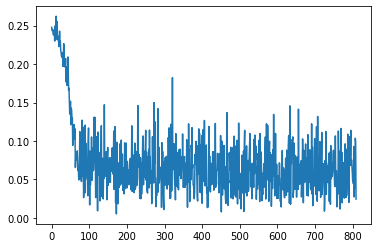

In [0]:
#plot losses over training
import matplotlib.pyplot as plt
plt.plot(losses)

Check model converged with lower learning rate.

In [0]:
#fine tune at static, low lr 
model_2, losses_2 = train_model(model_1, 1, 1e-7, 0)

Epoch 1......Step: 10/163....... Average Loss for Epoch: 0.06912937685847283
Epoch 1......Step: 20/163....... Average Loss for Epoch: 0.054211931442841886
Epoch 1......Step: 30/163....... Average Loss for Epoch: 0.05697781980658571
Epoch 1......Step: 40/163....... Average Loss for Epoch: 0.06276674505788833
Epoch 1......Step: 50/163....... Average Loss for Epoch: 0.06476938461884857
Epoch 1......Step: 60/163....... Average Loss for Epoch: 0.06466878624632955
Epoch 1......Step: 70/163....... Average Loss for Epoch: 0.06435088273137808
Epoch 1......Step: 80/163....... Average Loss for Epoch: 0.061621306056622416
Epoch 1......Step: 90/163....... Average Loss for Epoch: 0.06118816144557463
Epoch 1......Step: 100/163....... Average Loss for Epoch: 0.062347424672916534
Epoch 1......Step: 110/163....... Average Loss for Epoch: 0.06229871647771109
Epoch 1......Step: 120/163....... Average Loss for Epoch: 0.06133666372237106
Epoch 1......Step: 130/163....... Average Loss for Epoch: 0.0608332895

# Evaluate Model

In [0]:
def evaluate(model, validation_loader):
    model.eval()
    outputs = []
    targets = []
    for x,y in validation_loader:
      if len(x) == batch_size:
        targets.extend(y.numpy())
        h = model.inithidden(batch_size)
        x = x.unsqueeze(0)
        x = x.to(device)
        h = h.to(device)
        out, h = model(x, h)
        outputs.extend(out[0].cpu().detach().numpy())
    return outputs, targets

preds, targets = evaluate(model_2, dataloaders_dict['val'])
print(len(preds))
print(len(preds) == len(targets))

1680
True


In [0]:
injured_labels = [np.argmax(i) for i in targets]
injured_preds = [np.argmax(i) for i in preds]
acc = accuracy_score(injured_labels, injured_preds)
acc

0.9172619047619047

92% overall accuracy - however for 2-type classification we want to optimise for recall of injured patients (the potential cost of false negative is much higher than for a false positive)

# Optimising for injury recall

In [0]:
def thresh(x, t):
  if x > t: return 1
  else: return 0

thresholds = np.linspace(0.0, 0.3, 21)
recall_scores = []
accuracies = []
for t in thresholds:
  pred_class = [thresh(p[1], t) for p in preds]
  r = recall_score(injured_labels, pred_class, pos_label=1)
  a = accuracy_score(injured_labels, pred_class)
  recall_scores.append(r)
  accuracies.append(a)

Text(0, 0.5, 'Accuracy/Recall of positive cases')

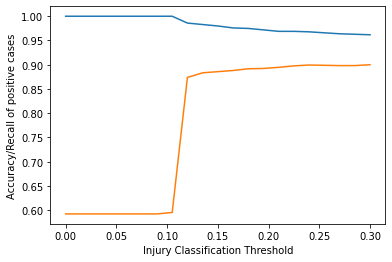

In [0]:
plt.plot(thresholds, recall_scores)
plt.plot(thresholds, accuracies)
plt.xlabel('Injury Classification Threshold')
plt.ylabel('Accuracy/Recall of positive cases')

In [0]:
final_preds = [thresh(p[1], 0.17) for p in preds]
print(classification_report(injured_labels, final_preds))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       685
           1       0.86      0.98      0.91       995

    accuracy                           0.89      1680
   macro avg       0.91      0.87      0.88      1680
weighted avg       0.90      0.89      0.89      1680



In [0]:
torch.save(model_2.state_dict(), 'drive/My Drive/ICH/models/gru_2type')

get output for entire train set for final random forest training

In [0]:
def predict(item, model):
  x = item.unsqueeze(0).unsqueeze(0)
  h = gru.inithidden(1)
  x = x.to(device)
  h = h.to(device)
  pred, _ = model(x, h)
  return pred

In [0]:
train_preds = []
batch_size = 1
for x in cnn_out_train:
  train_preds.append(predict(x, model_2))

In [0]:
labels = image_labels
train_healthy = [x[0][0][0].cpu().detach().numpy() for x in train_preds]
train_injured = [x[0][0][1].cpu().detach().numpy() for x in train_preds]

In [0]:
train_conf_scores = pd.DataFrame({'label': labels, 'healthy': train_healthy, 'injured': train_injured})
train_conf_scores.to_csv('drive/My Drive/ICH/Inference/train_2type_conf_scores.csv')

# Test Set Inference

Final inference for test set images

In [0]:
#load test set embeddings from vgg output
with open('drive/My Drive/ICH/Inference/CNN_2type_emb.npy', 'rb') as f:
  cnn_out_test = np.load(f, allow_pickle=True)
  cnn_out_test = [t.cpu() for t in cnn_out_test]

with open('drive/My Drive/ICH/Inference/CNN_2type_emb_refs.npy', 'rb') as f:
  image_labels_test = np.load(f, allow_pickle=True)
  image_labels_test = [i.split('.')[0] for i in image_labels_test]

In [0]:
test_preds = []
for x in cnn_out_test:
  test_preds.append(predict(x, model_2))

In [0]:
labels = image_labels_test
test_healthy = [x[0][0][0].cpu().detach().numpy() for x in test_preds]
test_injured = [x[0][0][1].cpu().detach().numpy() for x in test_preds]

test_conf_scores = pd.DataFrame({'label': labels, 'healthy': test_healthy, 'injured': test_injured})
test_conf_scores.to_csv('drive/My Drive/ICH/Inference/test_2type_conf_scores.csv')